In [1]:
import sys
sys.path.insert(0, "./../")

import os
import utils_modelling as utils

c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Bugi\miniconda3\envs\modeling\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

In [2]:
path_dataset = "./../../../dataset_used_split"
path_train = os.path.join(path_dataset, "train")
path_val = os.path.join(path_dataset, "val")
path_test = os.path.join(path_dataset, "test")

In [3]:
train_img, train_mask = utils.load_img_mask(path_train)
val_img, val_mask = utils.load_img_mask(path_val)
test_img, test_mask = utils.load_img_mask(path_test)

In [4]:
trainset = utils.create_dataset(train_img, train_mask)
valset = utils.create_dataset(val_img, val_mask)
testset = utils.create_dataset(test_img, test_mask)

In [5]:
unet_small = utils.custom_unet()
unet_small = utils.train_model(unet_small, trainset, valset, "unet_small")

In [8]:
unet_custom.evaluate(testset)

5/5 [==============================] - 2s 372ms/step - loss: 0.0432 - accuracy: 0.9830


[0.04324919730424881, 0.9829634428024292]

1/1 [==============================] - 1s 757ms/step
(16, 128, 128, 3)
42106


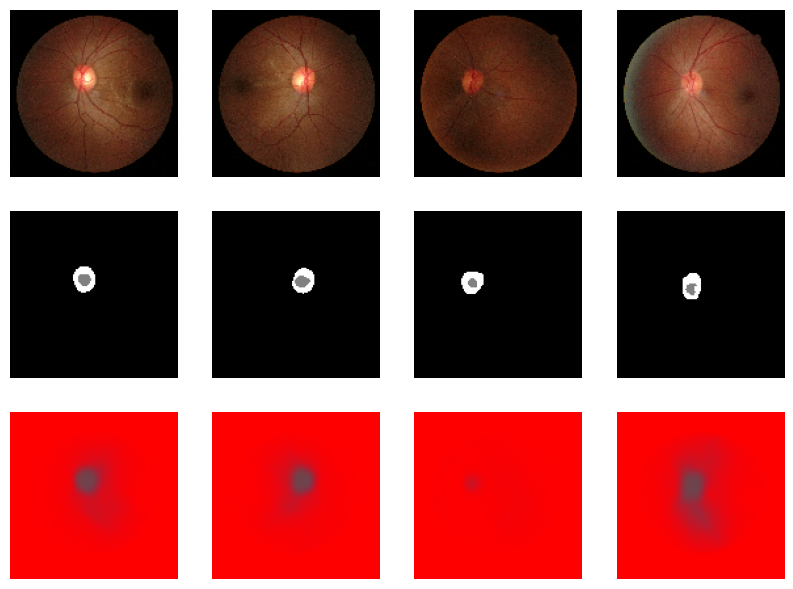

In [10]:
for image, mask in testset.take(1):
    pred = unet_custom.predict(image)

    print(pred.shape, len(np.unique(pred[0])), sep="\n")
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(4, 4, i+1)
        plt.imshow(image[i])
        plt.axis("off")
        plt.subplot(4, 4, i+5)
        plt.imshow(mask[i], cmap="gray")
        plt.axis("off")
        plt.subplot(4, 4, i+9)
        plt.imshow(pred[i], cmap="gray")
        plt.axis("off")
    break

In [11]:
int_mask = tf.argmax(pred[3], axis=-1).numpy()
print(int_mask.shape, np.unique(int_mask), sep="\n")

(128, 128)
[0]


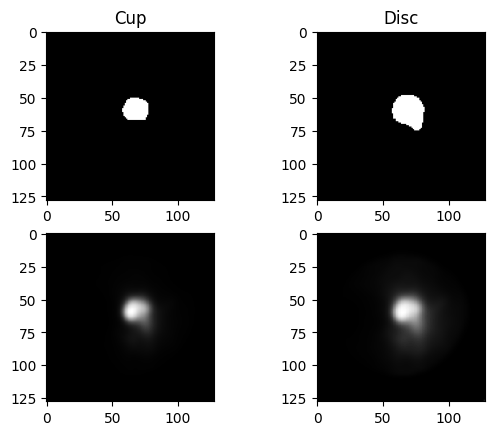

In [12]:
cup_mask = pred[..., 1]
disc_mask = pred[..., 2]
treshold = 0.1
img_idx = 12

plt.subplot(2, 2, 1)
plt.title('Cup')
plt.imshow(tf.where(cup_mask > treshold, 1, 0)[img_idx], cmap='gray')
plt.subplot(2, 2, 2)
plt.title('Disc')
plt.imshow(tf.where(disc_mask > treshold, 1, 0)[img_idx], cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(cup_mask[img_idx], cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(disc_mask[img_idx], cmap='gray')

plt.show()

In [14]:
print(f"median: {np.median(np.unique(disc_mask))}",
      f"max: {np.max(np.unique(disc_mask))}",
      sep="\n")

median: 6.856759604545459e-09
max: 0.30859053134918213


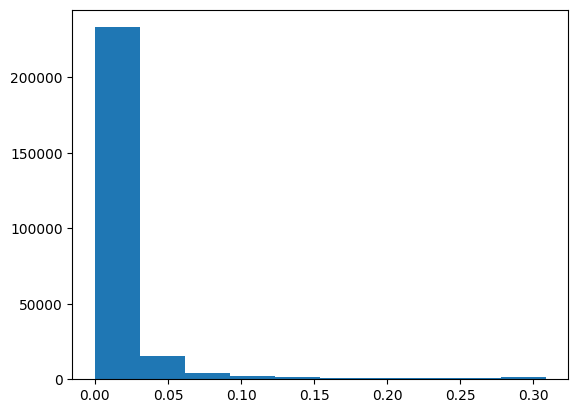

In [15]:
plt.hist(np.unique(disc_mask))
plt.show()

In [15]:
binary_cup = tf.where(cup_mask > treshold, 1, 0)
binary_disc = tf.where(disc_mask > treshold, 1, 0)

In [14]:
np.unique(disc_mask[0])

array([4.8240215e-16, 4.9498112e-16, 5.0056370e-16, ..., 2.9787141e-01,
       2.9821944e-01, 2.9863989e-01], dtype=float32)

In [16]:
# Get bounding box and dimensions for the disc
disc_ymin, disc_ymax, disc_xmin, disc_xmax, disc_height, disc_width = utils.get_bounding_box(binary_disc[0])

# Get bounding box and dimensions for the cup
cup_ymin, cup_ymax, cup_xmin, cup_xmax, cup_height, cup_width = utils.get_bounding_box(binary_cup[0])

# Print the results
print(f"Disc - Height: {disc_height}, Width: {disc_width}, Bounding Box: ({disc_ymin}, {disc_ymax}, {disc_xmin}, {disc_xmax})")
print(f"Cup - Height: {cup_height}, Width: {cup_width}, Bounding Box: ({cup_ymin}, {cup_ymax}, {cup_xmin}, {cup_xmax})")

Disc - Height: 47, Width: 28, Bounding Box: (37, 83, 48, 75)
Cup - Height: 23, Width: 21, Bounding Box: (42, 64, 49, 69)


### Visualize and Debug

In [19]:
for img, mask in trainset.take(1):
    break
np.unique(mask[2])

array([0, 1, 2])

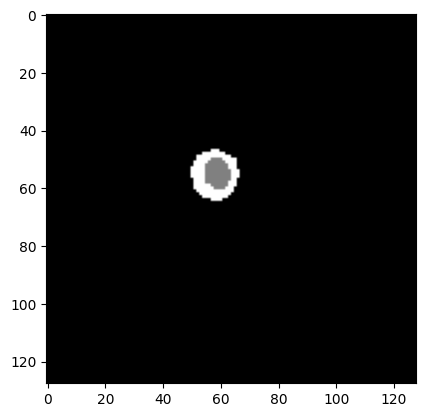

In [20]:
plt.imshow(mask[0], cmap="gray")

In [21]:
example_mask = train_mask[54]
example_mask = tf.io.read_file(example_mask)
example_mask = tf.image.decode_png(example_mask, channels=1)
example_mask = tf.image.resize(example_mask, (256, 256), method="nearest")
example_mask = tf.cast(example_mask, tf.int32)

dict_example = {}
for index, value in enumerate(sorted(np.unique(example_mask))):
    dict_example[value] = index
dict_example

{0: 0, 64: 1, 255: 2}

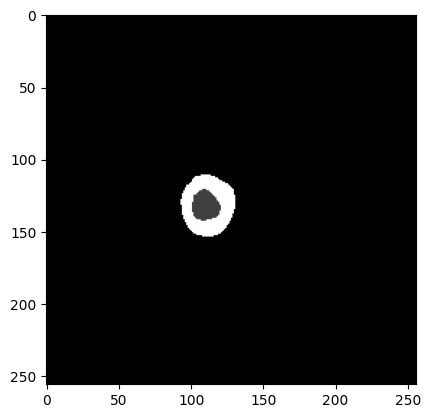

In [22]:
plt.imshow(example_mask, cmap="gray")

0 16 16


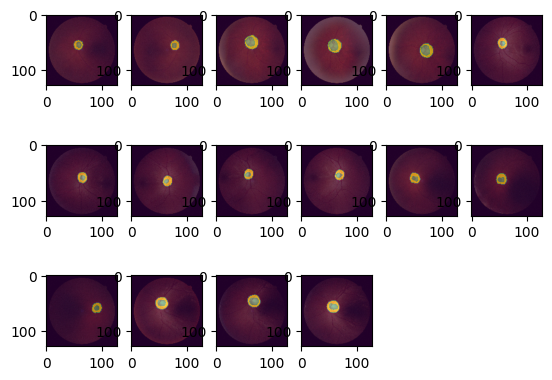

1 16 16


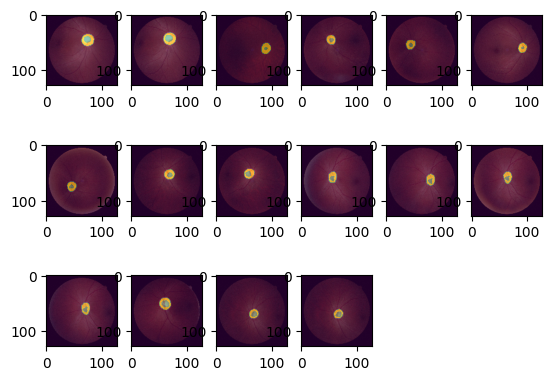

2 16 16


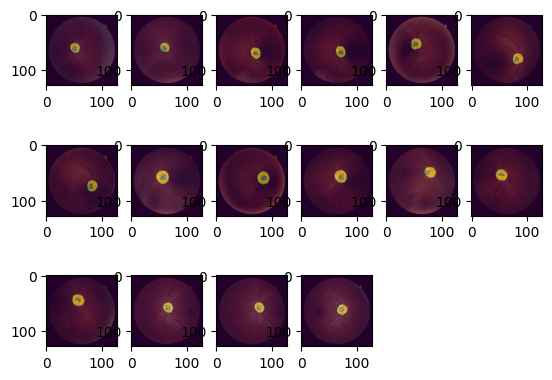

3 16 16


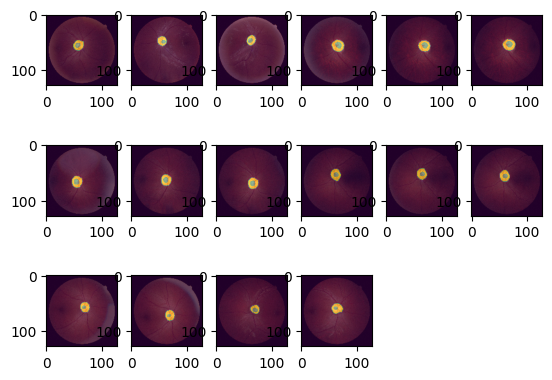

4 16 16


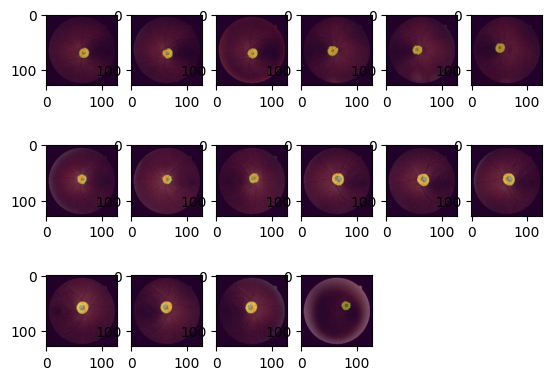

5 16 16


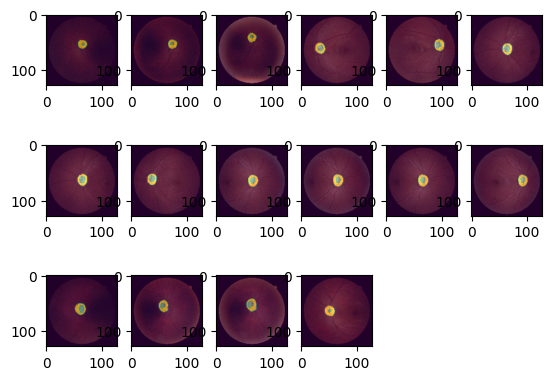

6 16 16


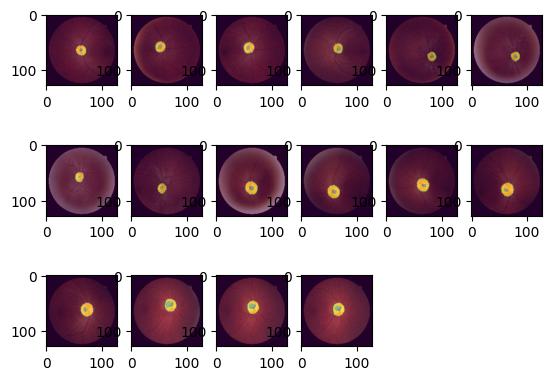

7 16 16


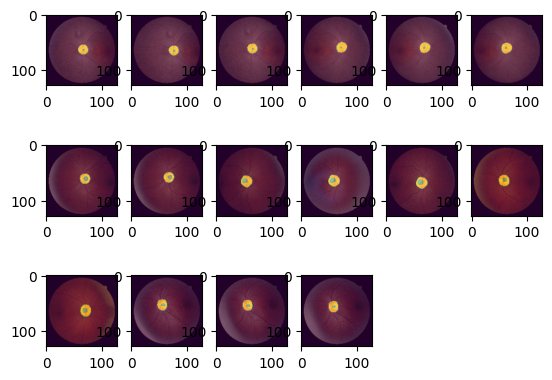

8 16 16


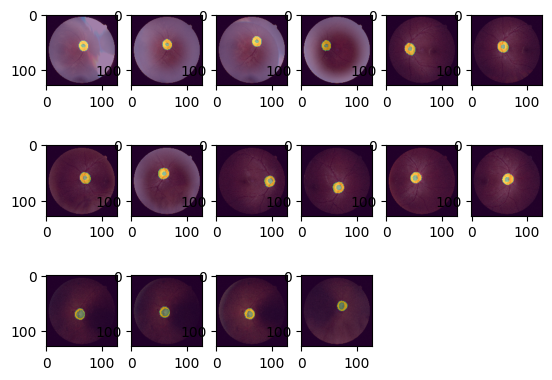

9 16 16


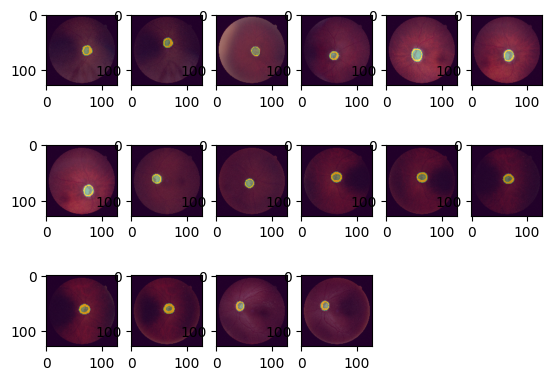

10 16 16


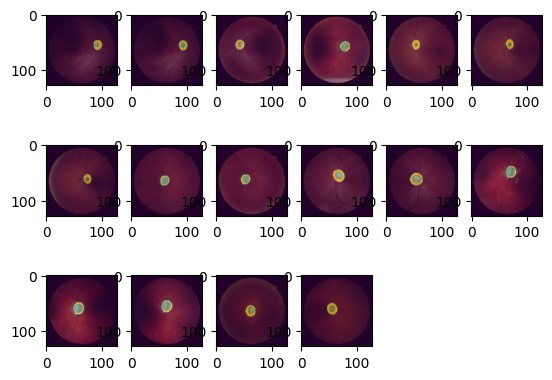

11 16 16


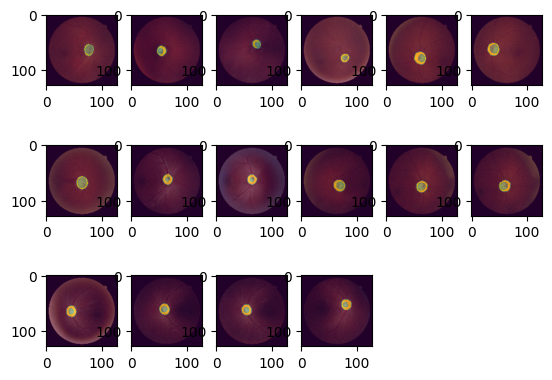

12 16 16


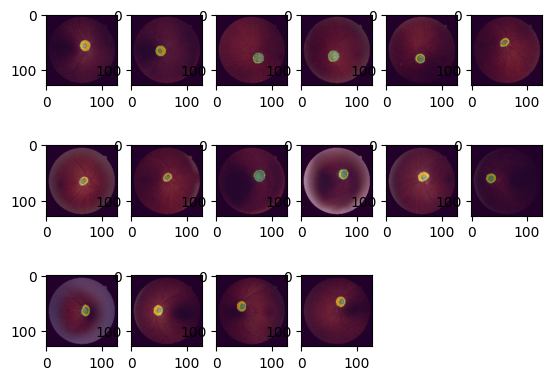

13 16 16


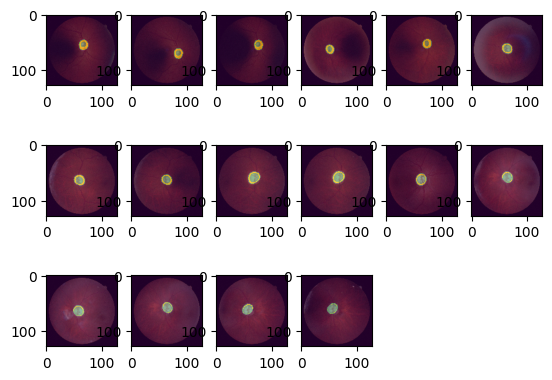

14 16 16


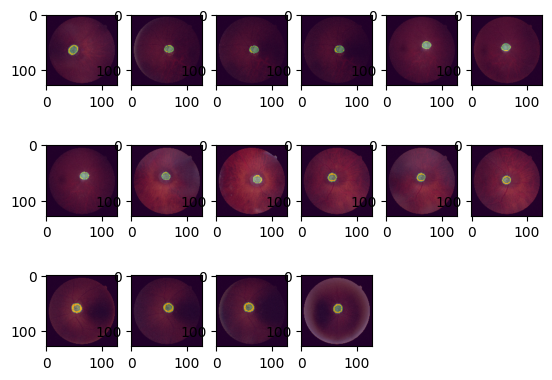

15 6 6


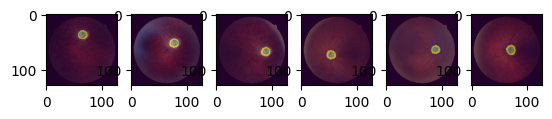

In [23]:
for indeks, (images, masks) in enumerate(trainset.take(16)):
    print(indeks, len(images), len(masks), sep=" ")
    for i in range(len(images)):
        plt.subplot(3, 6, i+1)
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha=0.5)
    plt.show()